# Normalizing flows: performing inference by hybrid message passing

## Load packages

In [ ]:
using Random
using LinearAlgebra
using PyPlot
using Distributions
using BenchmarkTools
using ProgressMeter
using Revise

using ReactiveMP
using GraphPPL
using Rocket;

## Generate data

In [2]:
function generate_data(nr_samples::Int64, model::FlowModel)

    # specify latent sampling distribution
    dist = MvNormal([1.5, 0.5], I)

    # sample from the latent distribution
    x = rand(dist, nr_samples)

    # transform data
    y = zeros(Float64, size(x))
    for k = 1:nr_samples
        y[:,k] .= forward(model, x[:,k])
    end

    # return data
    return y, x

end;

In [3]:
data_model = FlowModel((AdditiveCouplingLayer(PlanarFlow(5.0, -5.0, 5.0)),
                        AdditiveCouplingLayer(PlanarFlow(-5.0, 5.0, 1.0))))
data_y, data_x = generate_data(1000, data_model);

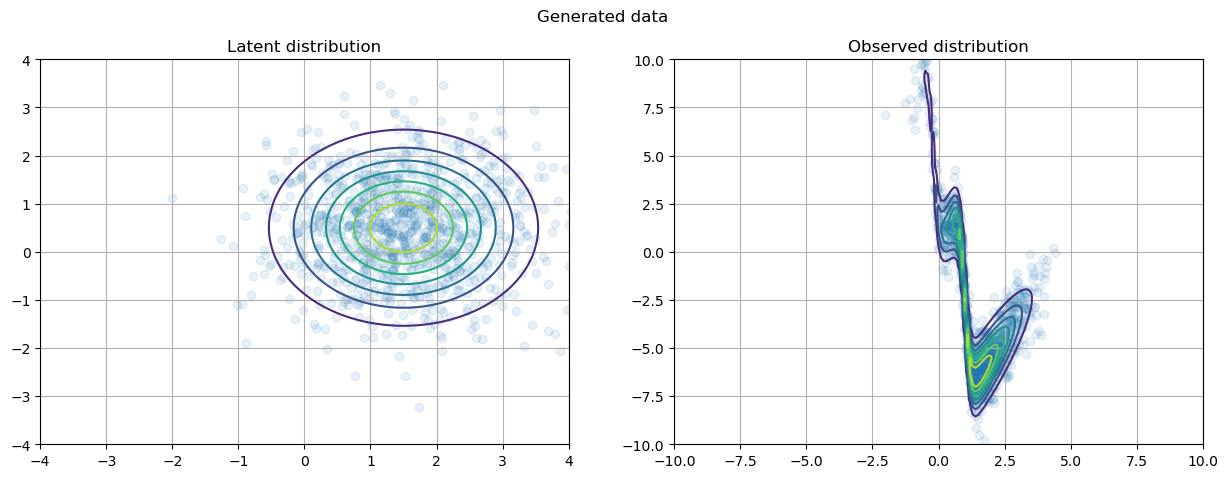

In [4]:
fig, ax = plt.subplots(ncols = 2, figsize=(15,5))
ax[1].scatter(data_x[1,:], data_x[2,:], alpha=0.1)
ax[1].contour(repeat(-5:0.1:5, 1, 101), repeat(-5:0.1:5, 1, 101)', map( (x) -> pdf(MvNormal([1.5, 0.5], I), [x...]), collect(Iterators.product(-5:0.1:5, -5:0.1:5))))
ax[2].scatter(data_y[1,:], data_y[2,:], alpha=0.1)
ax[2].contour(repeat(-10:0.1:10, 1, 201), repeat(-10:0.1:10, 1, 201)', map( (x) -> pdf(MvNormal([1.5, 0.5], I), backward(data_model, [x...])), collect(Iterators.product(-10:0.1:10, -10:0.1:10))))
ax[1].grid(), ax[2].grid()
ax[1].set_xlim(-4,4), ax[1].set_ylim(-4,4), ax[2].set_xlim(-10,10), ax[2].set_ylim(-10,10)
fig.suptitle("Generated data")
ax[1].set_title("Latent distribution"), ax[2].set_title("Observed distribution");

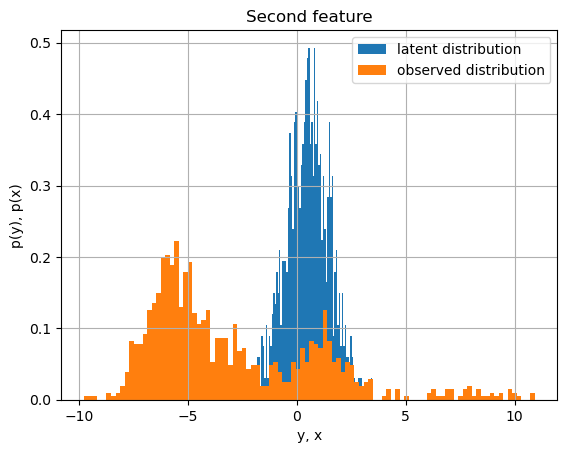

In [5]:
plt.hist(data_x[2,:], bins=100, density=true, alpha=1.0, label="latent distribution")
plt.hist(data_y[2,:], bins=100, density=true, alpha=1.0, label="observed distribution")
plt.grid(), plt.legend(), plt.ylabel("p(y), p(x)"), plt.xlabel("y, x"), plt.title("Second feature");
# first feature stays the same throughout the NICE flow

## Model specification

In [6]:
@model function normalizing_flow(nr_samples::Int64)
    
    # initialize variables
    z_μ   = randomvar()
    z_Λ   = randomvar()
    x     = randomvar(nr_samples)
    y_lat = randomvar(nr_samples)
    y     = datavar(Vector{Float64}, nr_samples)

    # specify prior
    z_μ ~ MvNormalMeanCovariance(zeros(2), huge*diagm(ones(2)))
    z_Λ ~ Wishart(2.0, tiny*diagm(ones(2)))

    # specify model
    model = FlowModel((AdditiveCouplingLayer(PlanarFlow(5.0, -5.0, 5.0)),
                       AdditiveCouplingLayer(PlanarFlow(-5.0, 5.0, 1.0))))
    meta = FlowMeta(model)

    # specify observations
    for k = 1:nr_samples

        # specify latent state
        x[k] ~ MvNormalMeanPrecision(z_μ, z_Λ) where { q = MeanField() }

        # specify transformed latent value
        y_lat[k] ~ Flow(x[k]) where { meta = meta }

        # specify observations
        y[k] ~ MvNormalMeanCovariance(y_lat[k], tiny*diagm(ones(2)))

    end

    # return variables
    return z_μ, z_Λ, x, y_lat, y

end;

## Probabilistic Inference

In [7]:
function inference_flow(data_y::Array{Array{Float64,1},1}; nr_iterations::Int64=10)
    
    # fetch number of samples
    nr_samples = length(data_y)

    # define model
    model, (z_μ, z_Λ, x, y_lat, y) = normalizing_flow(nr_samples)
    
    # initialize buffer for latent states
    mzμ = keep(Marginal)
    mzΛ = keep(Marginal)
    mx  = buffer(Marginal, nr_samples)
    my  = buffer(Marginal, nr_samples)

    # initialize free energy
    fe_values = Vector{Float64}()
    
    # subscribe to z
    zμ_sub = subscribe!(getmarginal(z_μ), mzμ)
    zΛ_sub = subscribe!(getmarginal(z_Λ), mzΛ)
    x_sub  = subscribe!(getmarginals(x), mx)
    y_sub  = subscribe!(getmarginals(y_lat), my)
    fe_sub = subscribe!(score(BetheFreeEnergy(), model), (fe) -> push!(fe_values, fe))

    # set initial marginals
    setmarginal!(z_μ, MvNormalMeanCovariance(zeros(2), huge*diagm(ones(2))))
    setmarginal!(z_Λ, Wishart(2.0, tiny*diagm(ones(2))))

    # update y according to observations (i.e. perform inference)
    @showprogress for it = 1:nr_iterations
        ReactiveMP.update!(y, data_y)
    end

    # unsubscribe
    unsubscribe!([zμ_sub, zΛ_sub, x_sub, y_sub, fe_sub])
    
    # return the marginal values
    return getvalues(mzμ)[end], getvalues(mzΛ)[end], getvalues(mx), getvalues(my), fe_values

end;

## Experimental validation

In [8]:
zμ_flow, zΛ_flow, x_flow, y_flow, fe_flow = inference_flow([data_y[:,k] for k=1:size(data_y,2)]);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


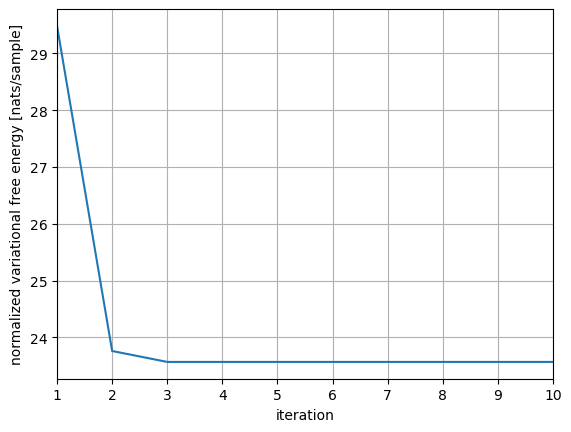

In [9]:
plt.plot(1:10, fe_flow/size(data_y,2))
plt.grid()
plt.xlim(1,10)
plt.xlabel("iteration")
plt.ylabel("normalized variational free energy [nats/sample]");

In [10]:
id = rand(1:size(data_y,2))
rand_observation = MvNormal(data_y[:,id], 5e-1*diagm(ones(2)))
warped_observation = MvNormal(backward(data_model, data_y[:,id]), inv_jacobian(data_model, data_y[:,id])*5e-1*diagm(ones(2))*inv_jacobian(data_model, data_y[:,id])');

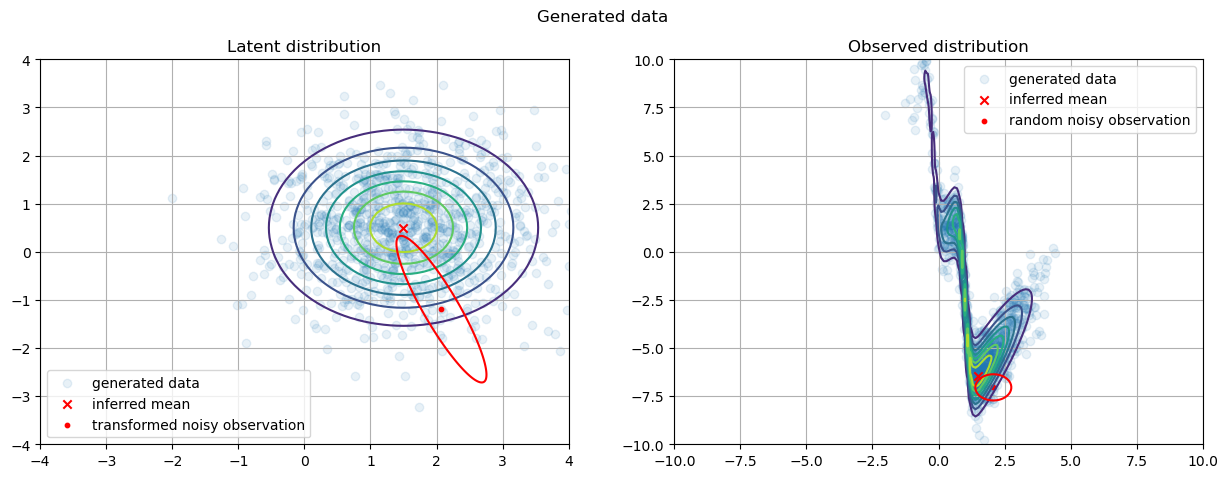

sys:1: UserWarning: The following kwargs were not used by contour: 'label'


In [11]:
fig, ax = plt.subplots(ncols = 2, figsize=(15,5))
ax[1].scatter(data_x[1,:], data_x[2,:], alpha=0.1, label="generated data")
ax[1].contour(repeat(-5:0.1:5, 1, 101), repeat(-5:0.1:5, 1, 101)', map( (x) -> pdf(MvNormal([1.5, 0.5], I), [x...]), collect(Iterators.product(-5:0.1:5, -5:0.1:5))), label="true distribution")
ax[1].scatter(mean(zμ_flow)[1], mean(zμ_flow)[2], color="red", marker="x", label="inferred mean")
ax[1].contour(repeat(-10:0.01:10, 1, 2001), repeat(-10:0.01:10, 1, 2001)', map( (x) -> pdf(warped_observation, [x...]), collect(Iterators.product(-10:0.01:10, -10:0.01:10))), colors="red", levels=1)
ax[1].scatter(mean(warped_observation)..., color="red", s=10, label="transformed noisy observation")
ax[2].scatter(data_y[1,:], data_y[2,:], alpha=0.1, label="generated data")
ax[2].scatter(forward(data_model, mean(zμ_flow))..., color="red", marker="x", label="inferred mean")
ax[2].contour(repeat(-10:0.1:10, 1, 201), repeat(-10:0.1:10, 1, 201)', map( (x) -> pdf(MvNormal([1.5, 0.5], I), backward(data_model, [x...])), collect(Iterators.product(-10:0.1:10, -10:0.1:10))))
ax[2].contour(repeat(-10:0.1:10, 1, 201), repeat(-10:0.1:10, 1, 201)', map( (x) -> pdf(rand_observation, [x...]), collect(Iterators.product(-10:0.1:10, -10:0.1:10))), colors="red", levels=1, label="random noisy observation")
ax[2].scatter(mean(rand_observation)..., color="red", s=10, label="random noisy observation")
ax[1].grid(), ax[2].grid()
ax[1].set_xlim(-4,4), ax[1].set_ylim(-4,4), ax[2].set_xlim(-10,10), ax[2].set_ylim(-10,10)
ax[1].legend(), ax[2].legend()
fig.suptitle("Generated data")
ax[1].set_title("Latent distribution"), ax[2].set_title("Observed distribution");